In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

In [93]:
def getKeyOfValue(val_):
    for key in word2idx.keys():
        if word2idx[key] == val_:
            print(key)

In [94]:
#word2idx["is"]
print(getKeyOfValue(1494))

is
None


In [2]:
data = pd.read_csv("ner_dataset.csv", encoding = "latin1")

In [3]:
data = data.fillna(method="ffill")

In [4]:
data.head(100)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
95,Sentence: 5,'s,POS,O
96,Sentence: 5,ruling,VBG,O
97,Sentence: 5,Labor,NNP,B-org
98,Sentence: 5,Party,NNP,I-org


In [5]:
words = list(set(data["Word"].values))

In [6]:
words.append("ENDPAD")

In [7]:
n_words = len(words); n_words

35179

In [8]:
tags = list(set(data["Tag"].values))

In [9]:
n_tags = len(tags); n_tags

17

In [10]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
    def getSentencePercentage(self, flt):
        dataset_size = len(self.sentences)
        ret = []
        for i,s in enumerate(self.sentences):
            if i < dataset_size*flt:
                ret.append(s)
        return ret

In [11]:
getter = SentenceGetter(data)

In [12]:
sent = getter.get_next()

In [13]:
sentences = getter.sentences
print(len(sentences))
len_sent = len(sentences)


47959


In [14]:
plt.style.use("ggplot")

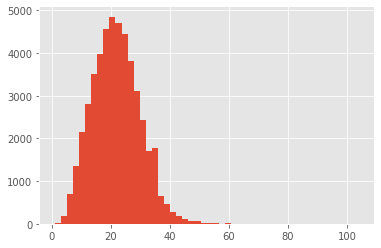

In [15]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [162]:
#here we use the defined amount of sentences
#print(len(sentences))

print(len_sent)
percentage_s = 0.1
sentences = getter.getSentencePercentage(percentage_s)
print(len(sentences))

#amount of sentences
words_sub = set()
tags_sub = set()

#get words of (partial) sentences and convert into indices
for i,s in enumerate(sentences):
    if i > len(sentences)-5:
        print(i)
    for w in s:
        words_sub.add(w[0])
        tags_sub.add(w[2])
max_len = 50
words_sub_list = list(words_sub)
words_sub_list.append("ENDPAD")


word2idx = {w: i for i, w in enumerate(words_sub_list)}
tag2idx = {t:i for i, t in enumerate(tags_sub)}

#generate dataset to split up later on
X = []
Y = []
for s in sentences:
    x_arr = []
    y_arr = []
    for w in s:
        x_arr.append(word2idx[w[0]])
        y_arr.append(tag2idx[w[2]])
    X.append(x_arr)
    Y.append(y_arr)

#convert to list to get access to indices
tags_sub = list(tags_sub)
n_words_sub = len(words_sub_list)
n_tags_sub = len(tags_sub)


X_pad = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words_sub-1)

#padd up data
Y_pad = pad_sequences(maxlen=max_len, sequences=Y, padding="post", value=tag2idx["O"])
Y_pad_cat = [to_categorical(i, num_classes=n_tags) for i in Y_pad]

X_tr, X_te, y_tr, y_te = train_test_split(X_pad, Y_pad_cat, test_size=0.1, shuffle=False)        


print("x train "+str(len(X_tr)))
print("y train "+str(len(y_tr)))
print("x test "+str(len(X_te)))
print("y test "+str(len(y_te))+"\n")
print("words_sub "+str(n_words_sub))
print("tags "+str(n_tags))
print("tags_sub "+str(n_tags_sub))

47959
4796
4792
4793
4794
4795
x train 4316
y train 4316
x test 480
y test 480

words_sub 11334
tags 17
tags_sub 17


In [149]:
print(len(words_sub_list))
print(n_words_sub)
print(words_sub_list[11333])

11334
11334
ENDPAD


In [129]:
print(getKeyOfValue(1))
print(n_words_sub)
print(getKeyOfValue(11334))

Irishman
None
11334
None


In [118]:
print(getKeyOfValue(1))
print(getKeyOfValue(n_words_sub-1))
for u in X_tr[0]:
    print(getKeyOfValue(u))

    


Irishman
None
None
Thousands
None
of
None
demonstrators
None
have
None
marched
None
through
None
London
None
to
None
protest
None
the
None
war
None
in
None
Iraq
None
and
None
demand
None
the
None
withdrawal
None
of
None
British
None
troops
None
from
None
that
None
country
None
.
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


## was bis jetzt machen?

- wir übergeben sätze statt nur einzelne wörter
- diese sätze beinhalten wörter und labels

- diese sätze werden auf ein bestimmtes padding (50) aufgefuellt, da keras inputs mit derselben laenge voraussetzt
- die saetze werden wiederum codiert: woerter werden als idx uebergeben, d.h. gleiche woerter haben als repraesentation dieselbe zahl
- die tags / labels werden ebenfalls als idx codiert, allerdings im anschluss noch kategorisiert (keras import)

### was aendern wir hier?
- ein word embedding würde dann hier jedoch die wörter in den sätzen selbst noch als 300d-vektor repräsentieren, statt einem einfachen idx

## MODEL CONFIG

In [150]:
input = Input(shape=(max_len,))
#n_words
model = Embedding(input_dim=n_words_sub, output_dim=50, input_length=max_len)(input)  # 50-dim embedding
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags_sub, activation="softmax"))(model)  # softmax output layer


model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [178]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
122/122 [==============================] - 7s 55ms/step - loss: 0.2056 - accuracy: 0.9422 - val_loss: 0.1521 - val_accuracy: 0.9567
Epoch 2/10
122/122 [==============================] - 8s 63ms/step - loss: 0.1459 - accuracy: 0.9557 - val_loss: 0.1298 - val_accuracy: 0.9634
Epoch 3/10
122/122 [==============================] - 7s 57ms/step - loss: 0.1114 - accuracy: 0.9687 - val_loss: 0.1067 - val_accuracy: 0.9717
Epoch 4/10
122/122 [==============================] - 7s 59ms/step - loss: 0.0858 - accuracy: 0.9766 - val_loss: 0.0996 - val_accuracy: 0.9710
Epoch 5/10
122/122 [==============================] - 7s 55ms/step - loss: 0.0687 - accuracy: 0.9811 - val_loss: 0.0822 - val_accuracy: 0.9766
Epoch 6/10
122/122 [==============================] - 8s 63ms/step - loss: 0.0574 - accuracy: 0.9846 - val_loss: 0.0771 - val_accuracy: 0.9780
Epoch 7/10
122/122 [==============================] - 7s 59ms/step - loss: 0.0495 - accuracy: 0.9865 - val_loss: 0.0806 - val_accuracy: 0.9762

In [179]:
hist = pd.DataFrame(history.history)
print(hist)

       loss  accuracy  val_loss  val_accuracy
0  0.205616  0.942183  0.152071      0.956667
1  0.145854  0.955731  0.129799      0.963426
2  0.111402  0.968692  0.106720      0.971667
3  0.085773  0.976555  0.099645      0.971018
4  0.068709  0.981056  0.082177      0.976620
5  0.057370  0.984557  0.077076      0.978009
6  0.049517  0.986483  0.080612      0.976204
7  0.043373  0.987981  0.074871      0.978056
8  0.038552  0.989382  0.072516      0.978981
9  0.034702  0.990324  0.074537      0.977963


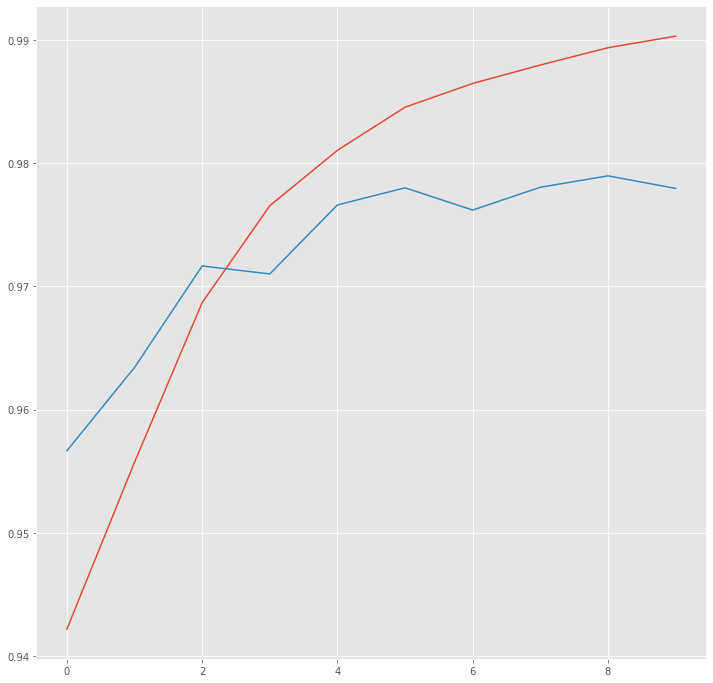

In [180]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [147]:
print(word2idx["Later"])

5551


In [181]:
i = 1
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
#prediction
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words_sub_list[w], tags_sub[pred])) 
print("\n")
#actual
sauce = len(X_tr) + i
for w, act in zip(X_pad[sauce], Y_pad[sauce]):
    print("{:15}: {}".format(words_sub_list[w], tags_sub[act])) 

Word            (True ): Pred
Later          : O
,              : O
Saddam         : B-per
Hussein        : I-per
is             : O
expected       : O
to             : O
be             : O
tried          : O
for            : O
other          : O
alleged        : O
crimes         : O
,              : O
including      : O
the            : O
1988           : B-tim
gassing        : I-org
of             : O
Kurds          : B-geo
in             : O
Halabja        : B-geo
and            : O
the            : O
1991           : B-tim
suppression    : O
of             : O
a              : O
Shi'ite        : B-org
uprising       : O
in             : O
southern       : B-geo
Iraq           : I-geo
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O